## Section 1: First we try PyTorch Quantization.
### This is the best available option as we will see, in terms of accuracy preservation.
### However, the FBGEMM backend is not available of FPGA and other embedded systems. In the next section we will implement Quantization from scratch

In [6]:
# import required packages
import os
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision
from torchvision import transforms, datasets
import numpy as np
import warnings
from resnet_18_sym import *
warnings.filterwarnings('ignore')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

torch.Size([16, 3, 64, 64])
torch.Size([16])


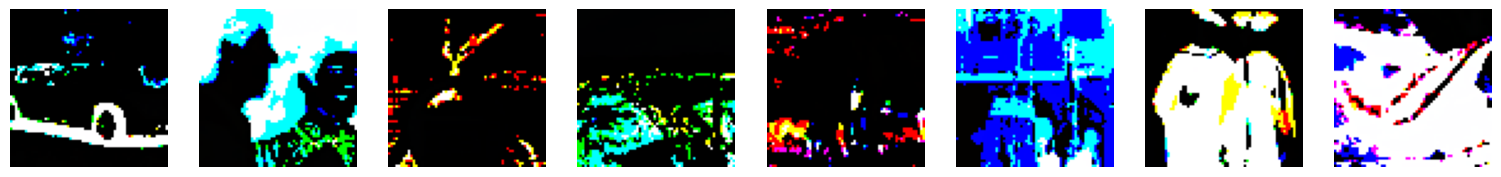

In [7]:
# Load and display samples from Tiny ImageNet  dataset
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
directory = "../../dataset/tiny-imagenet-200/"
num_classes = 200
# the magic normalization parameters come from the example
transform_mean = np.array([ 0.485, 0.456, 0.406 ])
transform_std = np.array([ 0.229, 0.224, 0.225 ])

val_transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.Resize(74),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])


##### Related to trainset , need only for label ids ##############
traindir = os.path.join(directory, "train")
bs = 16
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])
train = datasets.ImageFolder(traindir, train_transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)
assert num_classes == len(train_loader.dataset.classes)
small_labels = {}
with open(os.path.join(directory, "words.txt"), "r") as dictionary_file:
    line = dictionary_file.readline()
    while line:
        label_id, label = line.strip().split("\t")
        small_labels[label_id] = label
        line = dictionary_file.readline()
labels = {}
label_ids = {}
for label_index, label_id in enumerate(train_loader.dataset.classes):
    label = small_labels[label_id]
    labels[label_index] = label
    label_ids[label_id] = label_index
############# All these just to get the label ids ############################

valdir = os.path.join(directory, "val")

val = datasets.ImageFolder(valdir, val_transform)

val_loader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True)

small_labels = {}
with open(os.path.join(directory, "words.txt"), "r") as dictionary_file:
    line = dictionary_file.readline()
    while line:
        label_id, label = line.strip().split("\t")
        small_labels[label_id] = label
        line = dictionary_file.readline()


val_label_map = {}
with open(os.path.join(directory, "val/val_annotations.txt"), "r") as val_label_file:
    line = val_label_file.readline()
    while line:
        file_name, label_id, _, _, _, _ = line.strip().split("\t")
        val_label_map[file_name] = label_id
        line = val_label_file.readline()


for i in range(len(val_loader.dataset.imgs)):
    file_path = val_loader.dataset.imgs[i][0]

    file_name = os.path.basename(file_path)
    label_id = val_label_map[file_name]

    val_loader.dataset.imgs[i] = (file_path, label_ids[label_id])

images, labels = next(iter(val_loader))

print(images.shape)
print(labels.shape)

figure = plt.figure(figsize = (24,16))
num_of_images = 8
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1,2,0).numpy().squeeze().astype('uint8'), cmap='summer')


In [8]:
# ResNet Model - Defined in resnet_18_sym.py 
pretrained_model = "../tinyImagenet/tinyimg_resnet_sym.pt"
net = resnet18() 
sd = torch.load(pretrained_model, map_location=torch.device('cpu'))
net.load_state_dict(sd['net'])


<All keys matched successfully>

In [9]:
# Print the model for our help
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [10]:
# Helper function for getting the model size
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(MB):', round(os.path.getsize('temp.p')/(1024*1024),3))
    os.remove('temp.p')

In [11]:
print_size_of_model(net)

Size of the model(MB): 43.099


In [12]:
# Main accuracy testing function

def test(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False):
    model.to(device)
    model.eval()
    
    # Testing with qauntization if quantize=True
    if quantize:
#         modules_to_fuse = [['conv1', 'bn1'],
#                    ['layer1.0.conv1', 'layer1.0.bn1'],
#                    ['layer1.0.conv2', 'layer1.0.bn2'],
#                    ['layer1.1.conv1', 'layer1.1.bn1'],
#                    ['layer1.1.conv2', 'layer1.1.bn2'],
#                    ['layer2.0.conv1', 'layer2.0.bn1'],
#                    ['layer2.0.conv2', 'layer2.0.bn2'],
#                    ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
#                    ['layer2.1.conv1', 'layer2.1.bn1'],
#                    ['layer2.1.conv2', 'layer2.1.bn2'],
#                    ['layer3.0.conv1', 'layer3.0.bn1'],
#                    ['layer3.0.conv2', 'layer3.0.bn2'],
#                    ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
#                    ['layer3.1.conv1', 'layer3.1.bn1'],
#                    ['layer3.1.conv2', 'layer3.1.bn2'],
#                    ['layer4.0.conv1', 'layer4.0.bn1'],
#                    ['layer4.0.conv2', 'layer4.0.bn2'],
#                    ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
#                    ['layer4.1.conv1', 'layer4.1.bn1'],
#                    ['layer4.1.conv2', 'layer4.1.bn2']]
#         model = torch.quantization.fuse_modules(model, modules_to_fuse)
        if fbgemm:
            model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        else:
            model.qconfig = torch.quantization.default_qconfig
        torch.quantization.prepare(model, inplace=True)
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                model.forward(data)
            torch.quantization.convert(model, inplace=True)
            print("======= Quantization Done =====")


    #print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            #st = time.time()
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 4)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

In [13]:
# Baseline performance - unquantized model
device = 'cpu'
test(model=net, device=device, test_loader=val_loader, train_loader=train_loader, batch_size=bs)

========================================= PERFORMANCE =============================================
Size of the model(MB): 43.099
PyTorch optimized model test accuracy :54.81% 
Elapsed time = 21067.1997 milliseconds


In [8]:
# Quantization Performance
# Load the model to be quantized with Pytorch Quantization - Unfortunately this will fail
device = 'cpu'
import copy
netq = copy.deepcopy(net)
test(model=netq, device=device, test_loader=val_loader, train_loader=train_loader, batch_size=bs, quantize=True)

======= Quantization Done =====


NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Negative, UNKNOWN_TENSOR_TYPE_ID, QuantizedXPU, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, SparseCPU, SparseCUDA, SparseHIP, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, SparseVE, UNKNOWN_TENSOR_TYPE_ID, NestedTensorCUDA, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID, UNKNOWN_TENSOR_TYPE_ID].

QuantizedCPU: registered at ../aten/src/ATen/native/quantized/cpu/qconv.cpp:1423 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:133 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:51 [backend fallback]
AutogradMPS: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:59 [backend fallback]
AutogradXPU: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:43 [backend fallback]
AutogradHPU: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:68 [backend fallback]
AutogradLazy: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:55 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:295 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:481 [backend fallback]
Autocast: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:324 [backend fallback]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1064 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:89 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:137 [backend fallback]


### Huh! PyTorch Quantization fails for ResNet - in the QuantizedCPU implementations.
### Even if it worked, it would not help for FPGA implementation. The FBGEMM backend is not available of FPGA and other embedded systems. In the next section we will implement Quantization from scratch

In [14]:
# Routines for post training quantization - with calibration from scratch    
    
# Simple implementation for FPGA
# Routines for Quantization    

# Routines for Quantization 

from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
nb = 8
def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, num_bits=nb, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale_next = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale_next
  
  zero_point_next = 0
  if initial_zero_point < qmin:
      zero_point_next = qmin
  elif initial_zero_point > qmax:
      zero_point_next = qmax
  else:
      zero_point_next = initial_zero_point

  zero_point_next = int(zero_point_next)

  return scale_next, zero_point_next
  
def quantizeLayer(x, layer, stat, scale_x, zp_x, num_bits=nb):
  # for both conv and linear layers
  W = layer.weight.data
  #B = layer.bias.data

  # scale_x = x.scale
  # zp_x = x.zero_point
  w = quantize_tensor(layer.weight.data,num_bits) 
  #b = quantize_tensor(layer.bias.data,num_bits)

  layer.weight.data = w.tensor.float()
  #layer.bias.data = b.tensor.float()

  ####################################################################
  # This is Quantisation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  scale_w = w.scale
  zp_w = w.zero_point
  
  #scale_b = b.scale
  #zp_b = b.zero_point
  

  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Perparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = (scale_x * scale_w/scale_next)*(layer.weight.data - zp_w)
  #layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int

  x = (layer(X)/ scale_next) + zero_point_next 
    
  # Reset
  layer.weight.data = W
  #layer.bias.data = B
  
  return x, scale_next, zero_point_next


def quantForward(model, x, stats):
    
  # Quantise before inputting into incoming layers
  x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'])

  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['l10c1'], x.scale, x.zero_point)
  x = model.bn1(x)
  x = model.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].conv1, stats['l10c2'], scale_next, zero_point_next)
  x = model.layer1[0].bn1(x)
  x = model.layer1[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].conv2, stats['l11c1'], scale_next, zero_point_next)
  x = model.layer1[0].bn2(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].conv1, stats['l11c2'], scale_next, zero_point_next)
  x = model.layer1[1].bn1(x)
  x = model.layer1[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].conv2, stats['l20c1'], scale_next, zero_point_next)
  x = model.layer1[1].bn2(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].conv1, stats['l20c2'], scale_next, zero_point_next)
  x = model.layer2[0].bn1(x)
  x = model.layer2[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].conv2, stats['l21c1'], scale_next, zero_point_next)
  x = model.layer2[0].bn2(x)
  #x = model.layer2[0].downsample[0](x)
  #x = model.layer2[0].downsample[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].conv1, stats['l21c2'], scale_next, zero_point_next)
  x = model.layer2[1].bn1(x)
  x = model.layer2[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].conv2, stats['l30c1'], scale_next, zero_point_next)
  x = model.layer2[1].bn2(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].conv1, stats['l30c2'], scale_next, zero_point_next)
  x = model.layer3[0].bn1(x)
  x = model.layer3[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].conv2, stats['l31c1'], scale_next, zero_point_next)
  x = model.layer3[0].bn2(x)
  #x = model.layer3[0].downsample[0](x)
  #x = model.layer3[0].downsample[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].conv1, stats['l31c2'], scale_next, zero_point_next)
  x = model.layer3[1].bn1(x)
  x = model.layer3[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].conv2, stats['l40c1'], scale_next, zero_point_next)
  x = model.layer3[1].bn2(x)  

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[0].conv1, stats['l40c2'], scale_next, zero_point_next)
  x = model.layer4[0].bn1(x)
  x = model.layer4[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[0].conv2, stats['l41c1'], scale_next, zero_point_next)
  x = model.layer4[0].bn2(x)
  #x = model.layer4[0].downsample[0](x)
  #x = model.layer4[0].downsample[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[1].conv1, stats['l41c2'], scale_next, zero_point_next)
  x = model.layer4[1].bn1(x)
  x = model.layer4[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[1].conv2, stats['fc'], scale_next, zero_point_next)
  x = model.layer4[1].bn2(x)  

  x = x.view(-1, 512)   
  
  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
   
  x = model.fc(x)

  return x


# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)
  
  
  if key not in stats:
    stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    stats[key]['total'] += 1
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  x = model.conv1(x)
  x = model.bn1(x)
  x = model.relu(x)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l10c1')
  x = model.layer1[0].conv1(x)
  x = model.layer1[0].bn1(x)
  x = model.layer1[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l10c2')
  x = model.layer1[0].conv2(x)
  x = model.layer1[0].bn2(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l11c1')
  x = model.layer1[1].conv1(x)
  x = model.layer1[1].bn1(x)
  x = model.layer1[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l11c2')
  x = model.layer1[1].conv2(x)
  x = model.layer1[1].bn2(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l20c1')
  x = model.layer2[0].conv1(x)
  x = model.layer2[0].bn1(x)
  x = model.layer2[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l20c2')
  x = model.layer2[0].conv2(x)
  x = model.layer2[0].bn2(x)
  #x = model.layer2[0].downsample[0](x)
  #x = model.layer2[0].downsample[1](x)  
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l21c1')
  x = model.layer2[1].conv1(x)  
  x = model.layer2[1].bn1(x)
  x = model.layer2[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l21c2')
  x = model.layer2[1].conv2(x)  
  x = model.layer2[1].bn2(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l30c1')
  x = model.layer3[0].conv1(x)
  x = model.layer3[0].bn1(x)
  x = model.layer3[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l30c2')
  x = model.layer3[0].conv2(x)
  x = model.layer3[0].bn2(x)
  #x = model.layer3[0].downsample[0](x)
  #x = model.layer3[0].downsample[1](x) 
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l31c1')
  x = model.layer3[1].conv1(x)
  x = model.layer3[1].bn1(x)
  x = model.layer3[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l31c2')
  x = model.layer3[1].conv2(x)   
  x = model.layer3[1].bn2(x) 
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l40c1')
  x = model.layer4[0].conv1(x)
  x = model.layer4[0].bn1(x)
  x = model.layer4[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l40c2')
  x = model.layer4[0].conv2(x)
  x = model.layer4[0].bn2(x)
  #x = model.layer4[0].downsample[0](x)
  #x = model.layer4[0].downsample[1](x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l41c1')
  x = model.layer4[1].conv1(x)  
  x = model.layer4[1].bn1(x)
  x = model.layer4[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l41c2')
  x = model.layer4[1].conv2(x) 
  x = model.layer4[1].bn2(x) 
  x = x.view(-1, 512) 
  
  stats = updateStats(x, stats, 'fc')

  x = model.fc(x)

  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"] }
    return final_stats

# Routines for performance testing

def test(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False, stats=None):
    model.to(device)
    model.eval()
    
    #print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            #st = time.time()
            # Testing with qauntization if quantize=True
            if quantize:
                output = quantForward(model, X, stats)
            else:    
                output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 2)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

In [9]:
# Quantized model performance
import copy
netqq = copy.deepcopy(net)

# one time stats gathering - we will keep this stored for CIFAR for the FPGA implementation
stats = gatherStats(netqq, train_loader)
#stats = gatherStats(netqq, val_loader)
print(stats)

{'conv1': {'max': tensor(36.7482), 'min': tensor(-32.1422)}, 'l10c1': {'max': tensor(38.7957), 'min': tensor(0.)}, 'l10c2': {'max': tensor(22.1117), 'min': tensor(0.)}, 'l11c1': {'max': tensor(28.0266), 'min': tensor(-31.3525)}, 'l11c2': {'max': tensor(54.8396), 'min': tensor(0.)}, 'l20c1': {'max': tensor(115.4873), 'min': tensor(-77.0341)}, 'l20c2': {'max': tensor(55.0517), 'min': tensor(0.)}, 'l21c1': {'max': tensor(65.2899), 'min': tensor(-87.2813)}, 'l21c2': {'max': tensor(124.9165), 'min': tensor(0.)}, 'l30c1': {'max': tensor(228.7362), 'min': tensor(-288.0551)}, 'l30c2': {'max': tensor(375.3784), 'min': tensor(0.)}, 'l31c1': {'max': tensor(417.9812), 'min': tensor(-1539.9008)}, 'l31c2': {'max': tensor(2889.7170), 'min': tensor(0.)}, 'l40c1': {'max': tensor(4572.3633), 'min': tensor(-7050.4878)}, 'l40c2': {'max': tensor(4339.2695), 'min': tensor(0.)}, 'l41c1': {'max': tensor(29571.3613), 'min': tensor(-33935.4844)}, 'l41c2': {'max': tensor(4438.0610), 'min': tensor(0.)}, 'fc': {'m

In [13]:
# Quantized Inference
test(model=netqq, device=device, test_loader=val_loader, train_loader=train_loader, batch_size=bs, quantize=True, stats=stats)

========================================= PERFORMANCE =============================================
Size of the model(MB): 43.099
PyTorch optimized model test accuracy :1.0% 
Elapsed time = 43624.6240 milliseconds


### What 1% !!
### We must do a QAT to mitigate this

In [16]:
# Some more definitions required for the inference on the QAT model that we have trained offline
from collections import namedtuple

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

def calcScaleZeroPoint(min_val, max_val,num_bits=8):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1.

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def calcScaleZeroPointSym(min_val, max_val,num_bits=8):
  
  # Calc Scale 
  max_val = max(abs(min_val), abs(max_val))
  qmin = 0.
  qmax = 2.**(num_bits-1) - 1.

  scale = max_val / qmax

  return scale, 0

def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

def quantize_tensor_sym(x, num_bits=8, min_val=None, max_val=None):
    
    if not min_val and not max_val: 
      min_val, max_val = x.min(), x.max()

    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax   

    q_x = x/scale

    q_x.clamp_(-qmax, qmax).round_()
    q_x = q_x.round()
    return QTensor(tensor=q_x, scale=scale, zero_point=0)

def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

def quantizeLayer(x, layer, stat, scale_x, zp_x, vis=False, axs=None, X=None, y=None, sym=False, num_bits=8):
  # for both conv and linear layers

  # cache old values
  W = layer.weight.data
  B = layer.bias.data

  # WEIGHTS SIMULATED QUANTISED

  # quantise weights, activations are already quantised
  if sym:
    w = quantize_tensor_sym(layer.weight.data,num_bits=num_bits) 
    b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
  else:
    w = quantize_tensor(layer.weight.data, num_bits=num_bits) 
    b = quantize_tensor(layer.bias.data, num_bits=num_bits)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ## END WEIGHTS QUANTISED SIMULATION


  if vis:
    axs[X,y].set_xlabel("Visualising weights of layer: ")
    visualise(layer.weight.data, axs[X,y])

  # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
  # This is Quantisation Arithmetic
  scale_w = w.scale
  zp_w = w.zero_point
  scale_b = b.scale
  zp_b = b.zero_point
  
  if sym:
    scale_next, zero_point_next = calcScaleZeroPointSym(min_val=stat['min'], max_val=stat['max'])
  else:
    scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Preparing input by saturating range to num_bits range.
  if sym:
    X = x.float()
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data)
  else:
    X = x.float() - zp_x
    layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data - zp_w)
    layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int computation
  if sym:  
    x = (layer(X)) 
  else:
    x = (layer(X)) + zero_point_next 
  
  # cast to int
  x.round_()

  # Perform relu too
  x = F.relu(x)

  # Reset weights for next forward pass
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next

# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
  max_val, _ = torch.max(x, dim=1)
  min_val, _ = torch.min(x, dim=1)

  # add ema calculation

  if key not in stats:
    stats[key] = {'max': max_val.sum(), 'min': min_val.sum(), 'total': 1}
  else:
    stats[key]['max'] += max_val.sum().item()
    stats[key]['min'] += min_val.sum().item()
    if 'total' in stats[key]:
        stats[key]['total'] += 1
    else:
        stats[key]['total'] = 1
  
  weighting = 2.0 / (stats[key]['total']) + 1

  if 'ema_min' in stats[key]:
    stats[key]['ema_min'] = weighting*(min_val.mean().item()) + (1- weighting) * stats[key]['ema_min']
  else:
    stats[key]['ema_min'] = weighting*(min_val.mean().item())

  if 'ema_max' in stats[key]:
    stats[key]['ema_max'] = weighting*(max_val.mean().item()) + (1- weighting) * stats[key]['ema_max']
  else: 
    stats[key]['ema_max'] = weighting*(max_val.mean().item())

  stats[key]['min_val'] = stats[key]['min']/ stats[key]['total']
  stats[key]['max_val'] = stats[key]['max']/ stats[key]['total']
  
  return stats

# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  x = model.conv1(x)
  x = model.bn1(x)
  x = model.relu(x)

  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l10c1')
  x = model.layer1[0].conv1(x)
  x = model.layer1[0].bn1(x)
  x = model.layer1[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l10c2')
  x = model.layer1[0].conv2(x)
  x = model.layer1[0].bn2(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l11c1')
  x = model.layer1[1].conv1(x)
  x = model.layer1[1].bn1(x)
  x = model.layer1[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l11c2')
  x = model.layer1[1].conv2(x)
  x = model.layer1[1].bn2(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l20c1')
  x = model.layer2[0].conv1(x)
  x = model.layer2[0].bn1(x)
  x = model.layer2[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l20c2')
  x = model.layer2[0].conv2(x)
  x = model.layer2[0].bn2(x)
  #x = model.layer2[0].downsample[0](x)
  #x = model.layer2[0].downsample[1](x)  
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l21c1')
  x = model.layer2[1].conv1(x)  
  x = model.layer2[1].bn1(x)
  x = model.layer2[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l21c2')
  x = model.layer2[1].conv2(x)  
  x = model.layer2[1].bn2(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l30c1')
  x = model.layer3[0].conv1(x)
  x = model.layer3[0].bn1(x)
  x = model.layer3[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l30c2')
  x = model.layer3[0].conv2(x)
  x = model.layer3[0].bn2(x)
  #x = model.layer3[0].downsample[0](x)
  #x = model.layer3[0].downsample[1](x) 
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l31c1')
  x = model.layer3[1].conv1(x)
  x = model.layer3[1].bn1(x)
  x = model.layer3[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l31c2')
  x = model.layer3[1].conv2(x)   
  x = model.layer3[1].bn2(x) 
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l40c1')
  x = model.layer4[0].conv1(x)
  x = model.layer4[0].bn1(x)
  x = model.layer4[0].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l40c2')
  x = model.layer4[0].conv2(x)
  x = model.layer4[0].bn2(x)
  #x = model.layer4[0].downsample[0](x)
  #x = model.layer4[0].downsample[1](x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l41c1')
  x = model.layer4[1].conv1(x)  
  x = model.layer4[1].bn1(x)
  x = model.layer4[1].relu(x)
  stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l41c2')
  x = model.layer4[1].conv2(x) 
  x = model.layer4[1].bn2(x) 
  x = x.view(-1, 512) 
  
  stats = updateStats(x, stats, 'fc')

  x = model.fc(x)


  return stats

# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cpu'
    
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
      final_stats[key] = { "max" : value["max"] / value["total"], "min" : value["min"] / value["total"], "ema_min": value["ema_min"], "ema_max": value["ema_max"] }
    return final_stats

def quantForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8):
  X = 0
  y = 0
  # Quantise before inputting into incoming layers
  if sym:
    x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)
  else:
    x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)

  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['l10c1'], x.scale, x.zero_point)
  x = model.bn1(x)
  x = model.relu(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].conv1, stats['l10c2'], scale_next, zero_point_next)
  x = model.layer1[0].bn1(x)
  x = model.layer1[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[0].conv2, stats['l11c1'], scale_next, zero_point_next)
  x = model.layer1[0].bn2(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].conv1, stats['l11c2'], scale_next, zero_point_next)
  x = model.layer1[1].bn1(x)
  x = model.layer1[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer1[1].conv2, stats['l20c1'], scale_next, zero_point_next)
  x = model.layer1[1].bn2(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].conv1, stats['l20c2'], scale_next, zero_point_next)
  x = model.layer2[0].bn1(x)
  x = model.layer2[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[0].conv2, stats['l21c1'], scale_next, zero_point_next)
  x = model.layer2[0].bn2(x)
  #x = model.layer2[0].downsample[0](x)
  #x = model.layer2[0].downsample[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].conv1, stats['l21c2'], scale_next, zero_point_next)
  x = model.layer2[1].bn1(x)
  x = model.layer2[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer2[1].conv2, stats['l30c1'], scale_next, zero_point_next)
  x = model.layer2[1].bn2(x)

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].conv1, stats['l30c2'], scale_next, zero_point_next)
  x = model.layer3[0].bn1(x)
  x = model.layer3[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[0].conv2, stats['l31c1'], scale_next, zero_point_next)
  x = model.layer3[0].bn2(x)
  #x = model.layer3[0].downsample[0](x)
  #x = model.layer3[0].downsample[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].conv1, stats['l31c2'], scale_next, zero_point_next)
  x = model.layer3[1].bn1(x)
  x = model.layer3[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer3[1].conv2, stats['l40c1'], scale_next, zero_point_next)
  x = model.layer3[1].bn2(x)  

  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[0].conv1, stats['l40c2'], scale_next, zero_point_next)
  x = model.layer4[0].bn1(x)
  x = model.layer4[0].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[0].conv2, stats['l41c1'], scale_next, zero_point_next)
  x = model.layer4[0].bn2(x)
  #x = model.layer4[0].downsample[0](x)
  #x = model.layer4[0].downsample[1](x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[1].conv1, stats['l41c2'], scale_next, zero_point_next)
  x = model.layer4[1].bn1(x)
  x = model.layer4[1].relu(x)
  x, scale_next, zero_point_next = quantizeLayer(x, model.layer4[1].conv2, stats['fc'], scale_next, zero_point_next)
  x = model.layer4[1].bn2(x)  

  x = x.view(-1, 512)   
  
  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
   
  x = model.fc(x)

  return x

import torch

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=8, min_val=None, max_val=None):
        x = quantize_tensor(x,num_bits=num_bits, min_val=min_val, max_val=max_val)
        x = dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

def quantAwareTrainingForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8, act_quant=False):

  ######## Outer layer #######
  conv1weight = model.conv1.weight.data
  model.conv1.weight.data = FakeQuantOp.apply(model.conv1.weight.data, num_bits)
  x = model.conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['conv1']['ema_min'], stats['conv1']['ema_max'])
  x = model.bn1(x)
  x = model.relu(x)

  ######## layer 1 #######
  conv2weight = model.layer1[0].conv1.weight.data
  model.layer1[0].conv1.weight.data = FakeQuantOp.apply(model.layer1[0].conv1.weight.data, num_bits)
  x = model.layer1[0].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l10c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l10c1']['ema_min'], stats['l10c1']['ema_max'])
  x = model.layer1[0].bn1(x)
  x = model.layer1[0].relu(x)

  conv3weight = model.layer1[0].conv2.weight.data
  model.layer1[0].conv2.weight.data = FakeQuantOp.apply(model.layer1[0].conv2.weight.data, num_bits)
  x = model.layer1[0].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l10c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l10c2']['ema_min'], stats['l10c2']['ema_max'])
  x = model.layer1[0].bn2(x)


  conv4weight = model.layer1[1].conv1.weight.data
  model.layer1[1].conv1.weight.data = FakeQuantOp.apply(model.layer1[1].conv1.weight.data, num_bits)
  x = model.layer1[1].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l11c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l11c1']['ema_min'], stats['l11c1']['ema_max'])
  x = model.layer1[1].bn1(x)
  x = model.layer1[1].relu(x)

  conv5weight = model.layer1[1].conv2.weight.data
  model.layer1[1].conv2.weight.data = FakeQuantOp.apply(model.layer1[1].conv2.weight.data, num_bits)
  x = model.layer1[1].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l11c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l11c2']['ema_min'], stats['l11c2']['ema_max'])
  x = model.layer1[1].bn2(x)

  ######## layer 2 #######
  conv6weight = model.layer2[0].conv1.weight.data
  model.layer2[0].conv1.weight.data = FakeQuantOp.apply(model.layer2[0].conv1.weight.data, num_bits)
  x = model.layer2[0].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l20c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l20c1']['ema_min'], stats['l20c1']['ema_max'])
  x = model.layer2[0].bn1(x)
  x = model.layer2[0].relu(x)

  conv7weight = model.layer2[0].conv2.weight.data
  model.layer2[0].conv2.weight.data = FakeQuantOp.apply(model.layer2[0].conv2.weight.data, num_bits)
  x = model.layer2[0].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l20c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l20c2']['ema_min'], stats['l20c2']['ema_max'])
  x = model.layer2[0].bn2(x)

  conv8weight = model.layer2[1].conv1.weight.data
  model.layer2[1].conv1.weight.data = FakeQuantOp.apply(model.layer2[1].conv1.weight.data, num_bits)
  x = model.layer2[1].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l21c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l21c1']['ema_min'], stats['l21c1']['ema_max'])
  x = model.layer2[1].bn1(x)
  x = model.layer2[1].relu(x)

  conv9weight = model.layer2[1].conv2.weight.data
  model.layer2[1].conv2.weight.data = FakeQuantOp.apply(model.layer2[1].conv2.weight.data, num_bits)
  x = model.layer2[1].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l21c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l21c2']['ema_min'], stats['l21c2']['ema_max'])
  x = model.layer2[1].bn2(x)

  ######## layer 3 #######
  conv10weight = model.layer3[0].conv1.weight.data
  model.layer3[0].conv1.weight.data = FakeQuantOp.apply(model.layer3[0].conv1.weight.data, num_bits)
  x = model.layer3[0].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l30c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l30c1']['ema_min'], stats['l30c1']['ema_max'])
  x = model.layer3[0].bn1(x)
  x = model.layer3[0].relu(x)

  conv11weight = model.layer3[0].conv2.weight.data
  model.layer3[0].conv2.weight.data = FakeQuantOp.apply(model.layer3[0].conv2.weight.data, num_bits)
  x = model.layer3[0].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l30c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l30c2']['ema_min'], stats['l30c2']['ema_max'])
  x = model.layer3[0].bn2(x)

  conv12weight = model.layer3[1].conv1.weight.data
  model.layer3[1].conv1.weight.data = FakeQuantOp.apply(model.layer3[1].conv1.weight.data, num_bits)
  x = model.layer3[1].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l31c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l31c1']['ema_min'], stats['l31c1']['ema_max'])
  x = model.layer3[1].bn1(x)
  x = model.layer3[1].relu(x)

  conv13weight = model.layer3[1].conv2.weight.data
  model.layer3[1].conv2.weight.data = FakeQuantOp.apply(model.layer3[1].conv2.weight.data, num_bits)
  x = model.layer3[1].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l31c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l31c2']['ema_min'], stats['l31c2']['ema_max'])
  x = model.layer3[1].bn2(x)
  ######## layer 4 #######
  conv14weight = model.layer4[0].conv1.weight.data
  model.layer4[0].conv1.weight.data = FakeQuantOp.apply(model.layer4[0].conv1.weight.data, num_bits)
  x = model.layer4[0].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l40c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l40c1']['ema_min'], stats['l40c1']['ema_max'])
  x = model.layer4[0].bn1(x)
  x = model.layer4[0].relu(x)

  conv15weight = model.layer4[0].conv2.weight.data
  model.layer4[0].conv2.weight.data = FakeQuantOp.apply(model.layer4[0].conv2.weight.data, num_bits)
  x = model.layer4[0].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l40c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l40c2']['ema_min'], stats['l40c2']['ema_max'])
  x = model.layer4[0].bn2(x)
  conv16weight = model.layer4[1].conv1.weight.data
  model.layer4[1].conv1.weight.data = FakeQuantOp.apply(model.layer4[1].conv1.weight.data, num_bits)
  x = model.layer4[1].conv1(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l41c1')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l41c1']['ema_min'], stats['l41c1']['ema_max'])
  x = model.layer4[1].bn1(x)
  x = model.layer4[1].relu(x)

  conv17weight = model.layer4[1].conv2.weight.data
  model.layer4[1].conv2.weight.data = FakeQuantOp.apply(model.layer4[1].conv2.weight.data, num_bits)
  x = model.layer4[1].conv2(x)
  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'l41c2')
  if act_quant:
    x = FakeQuantOp.apply(x, num_bits, stats['l41c2']['ema_min'], stats['l41c2']['ema_max'])
  x = model.layer4[1].bn2(x)
  ######## layer ends  #######

  x = x.view(-1, 512) 
  x = model.fc(x)

  with torch.no_grad():
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc')


  return x, conv1weight, conv2weight, conv3weight, conv4weight, conv5weight, conv6weight, conv7weight, conv8weight, conv9weight, conv10weight, conv11weight, conv12weight, conv13weight, conv14weight, conv15weight, conv16weight,  conv17weight, stats
# Training
# Training
def tinytrain(epoch, trainloader, optimizer, criterion, model, device, stats, act_quant=False, num_bits=8):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        #outputs = net(inputs)
        outputs, conv1weight, conv2weight, conv3weight, conv4weight, conv5weight, conv6weight, conv7weight, conv8weight, conv9weight, conv10weight, conv11weight, conv12weight, conv13weight, conv14weight, conv15weight, conv16weight,  conv17weight, stats = quantAwareTrainingForward(model, inputs, stats, num_bits=num_bits, act_quant=act_quant)
        model.conv1.weight.data            = conv1weight
        model.layer1[0].conv1.weight.data  = conv2weight
        model.layer1[0].conv2.weight.data  = conv3weight
        model.layer1[1].conv1.weight.data  = conv4weight
        model.layer1[1].conv2.weight.data  = conv5weight
        model.layer2[0].conv1.weight.data  = conv6weight
        model.layer2[0].conv2.weight.data  = conv7weight
        model.layer2[1].conv1.weight.data  = conv8weight
        model.layer2[1].conv2.weight.data  = conv9weight
        model.layer3[0].conv1.weight.data  = conv10weight
        model.layer3[0].conv2.weight.data  = conv11weight
        model.layer3[1].conv1.weight.data  = conv12weight
        model.layer3[1].conv2.weight.data  = conv13weight
        model.layer4[0].conv1.weight.data  = conv14weight
        model.layer4[0].conv2.weight.data  = conv15weight
        model.layer4[1].conv1.weight.data  = conv16weight
        model.layer4[1].conv2.weight.data  = conv17weight
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test_qat(epoch, testloader, criterion, model, device, stats, act_quant, num_bits=8):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            #outputs = net(inputs)
            outputs, conv1weight, conv2weight, conv3weight, conv4weight, conv5weight, conv6weight, conv7weight, conv8weight, conv9weight, conv10weight, conv11weight, conv12weight, conv13weight, conv14weight, conv15weight, conv16weight,  conv17weight, stats = quantAwareTrainingForward(model, inputs, stats, num_bits=num_bits, act_quant=act_quant)
            model.conv1.weight.data  = conv1weight
            model.layer1[0].conv1.weight.data  = conv2weight
            model.layer1[0].conv2.weight.data  = conv3weight
            model.layer1[1].conv1.weight.data  = conv4weight
            model.layer1[1].conv2.weight.data  = conv5weight
            model.layer2[0].conv1.weight.data  = conv6weight
            model.layer2[0].conv2.weight.data  = conv7weight
            model.layer2[1].conv1.weight.data  = conv8weight
            model.layer2[1].conv2.weight.data  = conv9weight
            model.layer3[0].conv1.weight.data  = conv10weight
            model.layer3[0].conv2.weight.data  = conv11weight
            model.layer3[1].conv1.weight.data  = conv12weight
            model.layer3[1].conv2.weight.data  = conv13weight
            model.layer4[0].conv1.weight.data  = conv14weight
            model.layer4[0].conv2.weight.data  = conv15weight
            model.layer4[1].conv1.weight.data  = conv16weight
            model.layer4[1].conv2.weight.data  = conv17weight
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [12]:
# now we test the QAT trained model's inference accuracy
pretrained_modelqat = "./imgnet_qat.pt"
netqat = resnet18()
sdqat = torch.load(pretrained_modelqat, map_location=torch.device('cpu'))
netqat.load_state_dict(sdqat['net'])
stats = gatherStats(netqat, train_loader)
print(stats) 

{'conv1': {'max': tensor(36.7923), 'min': tensor(-32.1230), 'ema_min': -2.095098976261013, 'ema_max': 2.258808786659709}, 'l10c1': {'max': tensor(39.5794), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 2.4282742512021325}, 'l10c2': {'max': tensor(39.7469), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 2.422313869007823}, 'l11c1': {'max': tensor(37.0353), 'min': tensor(-34.4893), 'ema_min': -2.2891071027008882, 'ema_max': 2.4710703971788246}, 'l11c2': {'max': tensor(25.5671), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 1.710673799916138}, 'l20c1': {'max': tensor(27.0916), 'min': tensor(-28.5506), 'ema_min': -1.874331433451077, 'ema_max': 1.6695206791173693}, 'l20c2': {'max': tensor(20.2427), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 1.4272995114769114}, 'l21c1': {'max': tensor(19.3533), 'min': tensor(-19.7845), 'ema_min': -1.3202290642417511, 'ema_max': 1.28028257451499}, 'l21c2': {'max': tensor(14.8676), 'min': tensor(0.), 'ema_min': 0.0, 'ema_max': 0.9503214398620358}, 'l30c1': 

In [17]:
criterion = nn.CrossEntropyLoss()
epoch = 1
device='cpu'
act_quant = True 
test_qat(epoch, val_loader, criterion, netqat, device, stats, act_quant, num_bits=8)

0 625 Loss: 5.799 | Acc: 0.000% (0/16)
1 625 Loss: 5.876 | Acc: 0.000% (0/32)
2 625 Loss: 5.509 | Acc: 0.000% (0/48)
3 625 Loss: 4.977 | Acc: 4.688% (3/64)
4 625 Loss: 4.551 | Acc: 12.500% (10/80)
5 625 Loss: 4.272 | Acc: 14.583% (14/96)
6 625 Loss: 3.995 | Acc: 17.857% (20/112)
7 625 Loss: 3.917 | Acc: 18.750% (24/128)
8 625 Loss: 3.780 | Acc: 22.222% (32/144)
9 625 Loss: 3.689 | Acc: 24.375% (39/160)
10 625 Loss: 3.647 | Acc: 24.432% (43/176)
11 625 Loss: 3.606 | Acc: 24.479% (47/192)
12 625 Loss: 3.593 | Acc: 24.038% (50/208)
13 625 Loss: 3.563 | Acc: 24.107% (54/224)
14 625 Loss: 3.532 | Acc: 25.000% (60/240)
15 625 Loss: 3.473 | Acc: 25.781% (66/256)
16 625 Loss: 3.394 | Acc: 27.206% (74/272)
17 625 Loss: 3.379 | Acc: 26.389% (76/288)
18 625 Loss: 3.352 | Acc: 27.303% (83/304)
19 625 Loss: 3.327 | Acc: 27.500% (88/320)
20 625 Loss: 3.323 | Acc: 27.083% (91/336)
21 625 Loss: 3.300 | Acc: 27.273% (96/352)
22 625 Loss: 3.250 | Acc: 28.261% (104/368)
23 625 Loss: 3.272 | Acc: 27.865% 

183 625 Loss: 2.993 | Acc: 30.231% (890/2944)
184 625 Loss: 2.990 | Acc: 30.338% (898/2960)
185 625 Loss: 2.991 | Acc: 30.309% (902/2976)
186 625 Loss: 2.990 | Acc: 30.281% (906/2992)
187 625 Loss: 2.991 | Acc: 30.219% (909/3008)
188 625 Loss: 2.994 | Acc: 30.126% (911/3024)
189 625 Loss: 2.992 | Acc: 30.230% (919/3040)
190 625 Loss: 2.989 | Acc: 30.170% (922/3056)
191 625 Loss: 2.986 | Acc: 30.208% (928/3072)
192 625 Loss: 2.988 | Acc: 30.246% (934/3088)
193 625 Loss: 2.986 | Acc: 30.251% (939/3104)
194 625 Loss: 2.986 | Acc: 30.192% (942/3120)
195 625 Loss: 2.983 | Acc: 30.261% (949/3136)
196 625 Loss: 2.984 | Acc: 30.203% (952/3152)
197 625 Loss: 2.982 | Acc: 30.240% (958/3168)
198 625 Loss: 2.986 | Acc: 30.182% (961/3184)
199 625 Loss: 2.986 | Acc: 30.219% (967/3200)
200 625 Loss: 2.986 | Acc: 30.162% (970/3216)
201 625 Loss: 2.987 | Acc: 30.167% (975/3232)
202 625 Loss: 2.987 | Acc: 30.080% (977/3248)
203 625 Loss: 2.987 | Acc: 30.116% (983/3264)
204 625 Loss: 2.988 | Acc: 30.091%

360 625 Loss: 2.966 | Acc: 30.021% (1734/5776)
361 625 Loss: 2.967 | Acc: 30.024% (1739/5792)
362 625 Loss: 2.968 | Acc: 29.976% (1741/5808)
363 625 Loss: 2.966 | Acc: 29.962% (1745/5824)
364 625 Loss: 2.967 | Acc: 29.983% (1751/5840)
365 625 Loss: 2.965 | Acc: 30.020% (1758/5856)
366 625 Loss: 2.966 | Acc: 30.024% (1763/5872)
367 625 Loss: 2.965 | Acc: 30.061% (1770/5888)
368 625 Loss: 2.965 | Acc: 30.081% (1776/5904)
369 625 Loss: 2.965 | Acc: 30.068% (1780/5920)
370 625 Loss: 2.966 | Acc: 30.088% (1786/5936)
371 625 Loss: 2.965 | Acc: 30.124% (1793/5952)
372 625 Loss: 2.965 | Acc: 30.077% (1795/5968)
373 625 Loss: 2.967 | Acc: 30.097% (1801/5984)
374 625 Loss: 2.966 | Acc: 30.133% (1808/6000)
375 625 Loss: 2.965 | Acc: 30.136% (1813/6016)
376 625 Loss: 2.965 | Acc: 30.123% (1817/6032)
377 625 Loss: 2.967 | Acc: 30.076% (1819/6048)
378 625 Loss: 2.968 | Acc: 30.046% (1822/6064)
379 625 Loss: 2.969 | Acc: 30.016% (1825/6080)
380 625 Loss: 2.969 | Acc: 30.003% (1829/6096)
381 625 Loss:

539 625 Loss: 2.967 | Acc: 30.023% (2594/8640)
540 625 Loss: 2.967 | Acc: 30.025% (2599/8656)
541 625 Loss: 2.968 | Acc: 30.016% (2603/8672)
542 625 Loss: 2.968 | Acc: 30.030% (2609/8688)
543 625 Loss: 2.968 | Acc: 30.021% (2613/8704)
544 625 Loss: 2.967 | Acc: 30.023% (2618/8720)
545 625 Loss: 2.967 | Acc: 30.060% (2626/8736)
546 625 Loss: 2.967 | Acc: 30.050% (2630/8752)
547 625 Loss: 2.967 | Acc: 30.052% (2635/8768)
548 625 Loss: 2.966 | Acc: 30.089% (2643/8784)
549 625 Loss: 2.967 | Acc: 30.068% (2646/8800)
550 625 Loss: 2.967 | Acc: 30.048% (2649/8816)
551 625 Loss: 2.967 | Acc: 30.050% (2654/8832)
552 625 Loss: 2.967 | Acc: 30.063% (2660/8848)
553 625 Loss: 2.967 | Acc: 30.077% (2666/8864)
554 625 Loss: 2.967 | Acc: 30.079% (2671/8880)
555 625 Loss: 2.966 | Acc: 30.081% (2676/8896)
556 625 Loss: 2.967 | Acc: 30.049% (2678/8912)
557 625 Loss: 2.966 | Acc: 30.085% (2686/8928)
558 625 Loss: 2.965 | Acc: 30.110% (2693/8944)
559 625 Loss: 2.966 | Acc: 30.089% (2696/8960)
560 625 Loss:

### Ah! Now we get a decent performance with both activation and weight quantization. We will take this model to FPGA¶


## Section 3: DietCNN Inference - Multiplication Free
### The main efficacy of this is in the FPGA implementation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets

# For training
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import faiss
import sys
sys.path.insert(1, '../core')
from lut_utils_tiny import *
import warnings
warnings.filterwarnings('ignore')
from patchlib import *
import multiprocessing
from joblib import Parallel, delayed
from evalutils_resnet_imgnet import *


In [2]:
# Load and display samples from Tiny ImageNet  dataset
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
directory = "../../dataset/tiny-imagenet-200/"
num_classes = 200
# the magic normalization parameters come from the example
transform_mean = np.array([ 0.485, 0.456, 0.406 ])
transform_std = np.array([ 0.229, 0.224, 0.225 ])

val_transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.Resize(74),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])


##### Related to trainset , need only for label ids ##############
traindir = os.path.join(directory, "train")
bs = 16
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])
train = datasets.ImageFolder(traindir, train_transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)
assert num_classes == len(train_loader.dataset.classes)
small_labels = {}
with open(os.path.join(directory, "words.txt"), "r") as dictionary_file:
    line = dictionary_file.readline()
    while line:
        label_id, label = line.strip().split("\t")
        small_labels[label_id] = label
        line = dictionary_file.readline()
labels = {}
label_ids = {}
for label_index, label_id in enumerate(train_loader.dataset.classes):
    label = small_labels[label_id]
    labels[label_index] = label
    label_ids[label_id] = label_index
############# All these just to get the label ids ############################

valdir = os.path.join(directory, "val")

val = datasets.ImageFolder(valdir, val_transform)

val_loader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True)

small_labels = {}
with open(os.path.join(directory, "words.txt"), "r") as dictionary_file:
    line = dictionary_file.readline()
    while line:
        label_id, label = line.strip().split("\t")
        small_labels[label_id] = label
        line = dictionary_file.readline()


val_label_map = {}
with open(os.path.join(directory, "val/val_annotations.txt"), "r") as val_label_file:
    line = val_label_file.readline()
    while line:
        file_name, label_id, _, _, _, _ = line.strip().split("\t")
        val_label_map[file_name] = label_id
        line = val_label_file.readline()


for i in range(len(val_loader.dataset.imgs)):
    file_path = val_loader.dataset.imgs[i][0]

    file_name = os.path.basename(file_path)
    label_id = val_label_map[file_name]

    val_loader.dataset.imgs[i] = (file_path, label_ids[label_id])

images, labels = next(iter(val_loader))

print(images.shape)
print(labels.shape)


torch.Size([16, 3, 64, 64])
torch.Size([16])


In [3]:
# Test method for the DietCNN Tiny Image Net ResNet Network. 

HOWDY = 20000000 

# Test accuracy of symbolic inference
def test_fullsym_acc(model, data_iter, bss=1):
    correct = 0 
    total = 0 
    counter = 0
    model.eval()
    for data in data_iter:
        X, y = data
        if counter > HOWDY:
            break
        output = model.forward(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
            #if True:
                correct += 1
        
        counter +=bss 
        total += bss
        if(counter > 0 and counter % bss == 0):
            print("Full symbolic model test accuracy DietCNN :{}% ".format(100*round(correct/total, 4)))
    return round(correct/total, 4)

In [ ]:
# DietCNN HyperParameters - 3 main 
# 1. Image  and all activation symbols 
# 2 & 3. Symbols for CONV and FC layers dictionary 

index = faiss.read_index("./kmeans_resnet_tinyimgnet_c1_k1_s1_512_v1_noflt.index")

n_clusters=512

# using a single pixel patch as of now
conv_patch_size = (1, 1)
patch_size = (1, 1)
all_patch_size = (1, 1)

patch_stride = 1
# Hyperparameters 2 & 3. Symbols for CONV and FC layers dictionary 
n_cluster_conv_filters = 256
n_cluster_fc_filters = 128
conv_stride = 1

# this is the reverse dictionary - symbol to patch 
centroid_lut = index.reconstruct_n(0, n_clusters)

import pickle
# Load the CONV and FC dictionaries and the LUT that are created already
with open('imgnet_conv_flt.index', "rb") as f:
    filter_index_conv = pickle.load(f)
with open('imgnet_fc_flt.index', "rb") as f:
    filter_index_fc = pickle.load(f)
fc_lut = np.genfromtxt('./imgnet_fc_lut.txt', delimiter=',',dtype=np.int16)
conv_lut = np.genfromtxt('./imgnet_conv_lut.txt', delimiter=',',dtype=np.int16)
add_lut = np.genfromtxt('./imgnet_add_lut.txt', delimiter=',',dtype=np.int16)
relu_lut = np.genfromtxt('./imgnet_relu_lut.txt', delimiter=',',dtype=np.int16)

# this is the creation of symbolic model.
# All these steps are need in the desktop implementation to sync with PyTorch inference
# For FPGA implementation the DietCNN models are quite simple 

# ResNet Model - Defined in resnet_18_sym.py 
pretrained_modeld = "./tinyimg_resnet_sym_nbn_v1.pt"
netd = resnet18() 
sdd = torch.load(pretrained_modeld, map_location=torch.device('cpu'))
netd.load_state_dict(sdd['net'])



print(" Symbolic model loading started...")
t = time.process_time()
# Sorry did not get time to change the name from VGG :(
netsym = vgg_sym(netd,sdd, filter_index_conv, filter_index_fc, conv_lut, fc_lut, add_lut, 
                  relu_lut, n_clusters, index, centroid_lut, patch_size, patch_stride)

elapsed_time3 = time.process_time() - t
print("Symbolic model loading completed in:",elapsed_time3)
netsym.eval()
start_t = time.time()  
acc = test_fullsym_acc(netsym, val_loader)
end = time.time()
print("elapsed time for symbolic inference:", end - start_t) 

 Symbolic model loading started...
Symbolic model loading completed in: 11.792554755000001
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing...
Full symbolic model test accuracy DietCNN :0.0% 
Inferencing..

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/home/swarnava/Projects/Work/aiml/symbol/lib/python3.10/site-packages/joblib/__init__.py", line 113, in <module>
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    from .memory import Memory, MemorizedResult, register_store_backend
  File "/home/swarnava/Projects/Work/aiml/symbol/lib/python3.10/site-packages/joblib/memory.py", line 16, in <module>
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.1

error with item: 4


Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.10/runpy.py", line 110, in _get_module_details
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    __import__(pkg_name)
  File "/home/swarnava/Projects/Work/aiml/symbol/lib/python3.10/site-packages/joblib/__init__.py", line 113, in <module>
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    from .memory import Memory, MemorizedResult, register_store_backend
  File "/home/swarnava/Projects/Work/aiml/symbol/lib/python3.10/site-packages/joblib/memory.py", line 32,

error with item: 5
